# 04 — Regression: outliers + near-duplicates (Datalab)

Cleanlab's Datalab also supports **regression** datasets. Here we use `california_housing`, which contains natural outliers.

We:
- Train a baseline regressor
- Run Datalab to detect dataset issues
- Retrain after pruning flagged outliers/label issues and compare metrics


In [1]:
from pathlib import Path
import sys

cwd = Path.cwd()
if (cwd / "src").exists():
    sys.path.insert(0, str(cwd / "src"))
elif (cwd.parent / "src").exists():
    sys.path.insert(0, str(cwd.parent / "src"))


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cleanlab_demo.config import CleanlabConfig, DatasetName, DemoConfig, ModelConfig, ModelName, RunConfig
from cleanlab_demo.experiments import run_experiment
from cleanlab_demo.settings import settings

sns.set_theme(style="whitegrid")
settings.ensure_dirs()


## 1) Run experiment

In [3]:
cfg = RunConfig(
    dataset=DatasetName.california_housing,
    model=ModelConfig(name=ModelName.hist_gradient_boosting),
    demo=DemoConfig(max_rows=8000),
    cleanlab=CleanlabConfig(
        enabled=True,
        use_datalab=True,
        datalab_fast=True,
        prune_and_retrain=True,
        prune_fraction=0.02,
    ),
)

result = run_experiment(cfg)
pd.DataFrame(
    [
        {"variant": v.variant.value, "primary": v.metrics.primary, **(v.metrics.details or {}), **(v.notes or {})}
        for v in result.variants
    ]
)


2026-02-08 02:34:31 | INFO     | cleanlab_demo | Loading dataset: california_housing
2026-02-08 02:34:31 | INFO     | sklearn.datasets._california_housing | Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to data/california_housing
2026-02-08 02:34:32 | INFO     | cleanlab_demo | Dataset loaded: 8,000 rows
/Users/rezami/PycharmProjects/Cleanlab_demo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,variant,primary,r2,mae,rmse,n_pruned
0,baseline,0.820042,0.820042,0.329482,0.493764,NaN
1,pruned_retrain,0.823214,0.823214,0.324250,0.489394,128.0


## 2) Datalab summary

In [4]:
pd.DataFrame(result.cleanlab_summary.get("datalab_issue_summary", []))


,issue_type,score,num_issues
0,label,0.413868,0
1,outlier,0.361927,434
2,near_duplicate,0.623867,52
3,non_iid,0.809821,0


## 3) Inspect outlier scores

The runner saves the full Datalab issue table to `artifacts/last_datalab_issues.csv`.

In [5]:
issues_path = settings.artifacts_dir / "last_datalab_issues.csv"
issues_path.exists(), issues_path


(True, PosixPath('artifacts/last_datalab_issues.csv'))

In [6]:
issues_df = pd.read_csv(issues_path)
issues_df.head()


,is_label_issue,label_score,is_outlier_issue,outlier_score,is_near_duplicate_issue,near_duplicate_score,is_non_iid_issue,non_iid_score
0,False,0.614937,False,0.316596,False,0.684594,False,0.900112
1,False,0.481169,False,0.432450,False,0.593955,False,0.928120
2,False,0.147715,False,0.356191,False,0.682669,False,0.929818
3,False,0.180577,False,0.740787,False,0.208009,False,0.910803
4,False,0.452534,False,0.405258,False,0.552224,False,0.934955


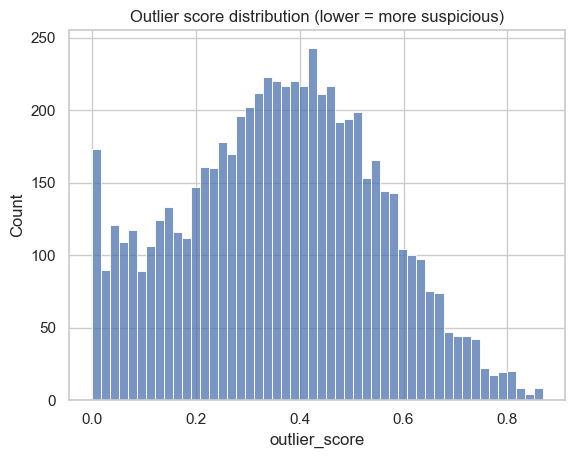

In [7]:
if "outlier_score" in issues_df.columns:
    ax = sns.histplot(issues_df["outlier_score"], bins=50)
    ax.set_title("Outlier score distribution (lower = more suspicious)")
    ax


In [8]:
top_outliers = issues_df.sort_values("outlier_score", ascending=True).head(20)
top_outliers


,is_label_issue,label_score,is_outlier_issue,outlier_score,is_near_duplicate_issue,near_duplicate_score,is_non_iid_issue,non_iid_score
5930,False,0.025087,True,4.689028e-07,False,1.000000,False,0.896355
863,False,0.079902,True,4.946782e-07,False,1.000000,False,0.965703
2690,False,0.007007,True,6.547235e-06,False,1.000000,False,0.963170
202,False,0.404728,True,9.414549e-06,False,1.000000,False,0.911346
4727,False,0.383018,True,1.022320e-05,False,1.000000,False,0.868721
3383,False,0.062882,True,1.711581e-05,False,1.000000,False,0.927643
1705,False,0.053838,True,2.173906e-05,False,1.000000,False,0.922983
544,False,0.154792,True,3.048953e-05,False,1.000000,False,0.914626
4771,False,0.064215,True,5.620481e-05,False,1.000000,False,0.842711
6129,False,0.613872,True,8.353061e-05,False,0.999918,False,0.872050
